# Data

Read in the three files: clients.csv, loans.csv, payments.csv. These files are related by the following:
1. The clients file is the parent of the loans file. Each client can have multiple distinct loans. The client_id column links the two files
2. The loans file is the child of the clients file and the parent of the payments file. Each loan can have multiple distinct payments associated with it. The loan_id column links the two files.

With the above datasets, answer the following questions. Show the steps taken to produce your final answer.

In [41]:
# Importing all packages I will need for answering all questions.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import stats # To run ANOVA.
import random                 # To select samples.
from patsy import dmatrices   # To build design matrices.
import statsmodels.api as sm  # Statistical models.
import statistics


Read the three CSV files into dataframes. Check their structure, shape and desribe their statistics. Examine the data.

In [2]:
# Read the files.
clients = pd.read_csv('clients.csv')
loans = pd.read_csv('loans.csv')
payments = pd.read_csv('payments.csv')

In [3]:
# Check their structure.
clients.info()
loans.info()
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   client_id     25 non-null     int64 
 1   joined        25 non-null     object
 2   income        25 non-null     int64 
 3   credit_score  25 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 928.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    443 non-null    int64  
 1   loan_type    443 non-null    object 
 2   loan_amount  443 non-null    int64  
 3   repaid       443 non-null    int64  
 4   loan_id      443 non-null    int64  
 5   loan_start   443 non-null    object 
 6   loan_end     443 non-null    object 
 7   rate         443 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 27.8+ KB
<cla

In [4]:
# Print their shapes.
print(f'clients: {clients.shape}')
print(f'loans: {loans.shape}')
print(f'payments: {payments.shape}')

clients: (25, 4)
loans: (443, 8)
payments: (3456, 4)


In [5]:
clients.head()

,client_id,joined,income,credit_score
0,46109,2002-04-16,172677,527
1,49545,2007-11-14,104564,770
2,41480,2013-03-11,122607,585
3,46180,2001-11-06,43851,562
4,25707,2006-10-06,211422,621


In [6]:
loans.head()

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,46109,home,13672,0,10243,2002-04-16,2003-12-20,2.15
1,46109,credit,9794,0,10984,2003-10-21,2005-07-17,1.25
2,46109,home,12734,1,10990,2006-02-01,2007-07-05,0.68
3,46109,cash,12518,1,10596,2010-12-08,2013-05-05,1.24
4,46109,credit,14049,1,11415,2010-07-07,2012-05-21,3.13


In [7]:
payments.head()

,loan_id,payment_amount,payment_date,missed
0,10243,2369,2002-05-31,1
1,10243,2439,2002-06-18,1
2,10243,2662,2002-06-29,0
3,10243,2268,2002-07-20,0
4,10243,2027,2002-07-31,1


Convert all columns with a data into datetime.

In [8]:
clients['joined'] = pd.to_datetime(clients['joined'])
loans['loan_start'] = pd.to_datetime(loans['loan_start'])
loans['loan_end'] = pd.to_datetime(loans['loan_end'])

# Check their structure.
clients.info()
loans.info()
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   client_id     25 non-null     int64         
 1   joined        25 non-null     datetime64[ns]
 2   income        25 non-null     int64         
 3   credit_score  25 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 928.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   client_id    443 non-null    int64         
 1   loan_type    443 non-null    object        
 2   loan_amount  443 non-null    int64         
 3   repaid       443 non-null    int64         
 4   loan_id      443 non-null    int64         
 5   loan_start   443 non-null    datetime64[ns]
 6   loan_end     443 non-null    dateti

In [9]:
# Forgot to convert payment_date in payments.
payments['payment_date'] = pd.to_datetime(payments['payment_date'])
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_id         3456 non-null   int64         
 1   payment_amount  3456 non-null   int64         
 2   payment_date    3456 non-null   datetime64[ns]
 3   missed          3456 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 108.1 KB


# Section 1 Questions

1. Give the 5 client IDs with the highest mean payment amount
2. How many unique loans have been given out to clients who joined prior to 2001?
3. What is the mean number of payments missed by clients with a credit score of less than 700 and who have missed more than 50 payments?

1. Get the 5 client IDs with the highest mean payment amount.

In [10]:
# loan_ids with highest mean payment amount.
highest_loan_ids = payments[['loan_id', 'payment_amount']]. \
                   groupby('loan_id'). \
                   mean(). \
                   sort_values(ascending=False, by='payment_amount'). \
                   head(5)
# Client ids with top 5 mean payment amount.
pd.merge(highest_loan_ids, loans, on='loan_id')['client_id']

0    38537
1    49545
2    26695
3    35214
4    29841
Name: client_id, dtype: int64

2. Unique loans given out to clients who joined prior to 2001. I am assuming that prior to means joined on or before 31-Dec-2000.

In [11]:
clients_prior_to_2001 = clients.loc[clients['joined'].dt.year < 2001]['client_id']
pd.merge(clients_prior_to_2001, loans, on='client_id')

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
0,42320,home,8090,0,10156,2012-09-22,2015-04-17,3.18
1,42320,cash,13643,1,10728,2002-08-04,2004-05-10,1.30
2,42320,home,5784,1,10909,2005-06-22,2007-06-19,1.97
3,42320,cash,5974,0,11538,2006-01-19,2008-04-29,2.51
4,42320,credit,8517,1,10624,2000-12-02,2002-11-06,0.64
5,42320,cash,3241,0,11882,2001-12-13,2004-01-12,0.69
6,42320,other,8367,1,11812,2007-08-24,2009-06-16,6.74
7,42320,cash,7906,0,11733,2006-02-12,2007-09-17,3.68
8,42320,home,12090,1,11443,2010-03-07,2011-09-12,1.28
9,42320,other,9498,0,11770,2003-07-24,2006-01-23,2.26


3. The mean number of payments missed by clients with a credit score of less than 700 and who have missed more than 50 payments?

In [12]:
# Clients with credit score < 700.
clients_poor_cs = clients.loc[clients['credit_score'] < 700]['client_id']
# Loan ids of these clients.
loan_ids_poor_cs = pd.merge(clients_poor_cs, loans, on='client_id')[['client_id', 'loan_id']]
# Payment details of these clients.
payments_poor_cs = pd.merge(loan_ids_poor_cs, payments, on='loan_id')
# Get count of missed payments by client.
missed_payments = payments_poor_cs.loc[payments_poor_cs['missed'] == 1].groupby('client_id').count()['missed']
# Get the mean number of missed payments where the missed count > 50. 
ans3 = missed_payments[missed_payments > 50].mean()
print(f'The mean number of payments missed by clients with a credit score of less than 700 and who have missed more than 50 payments = {ans3}')


The mean number of payments missed by clients with a credit score of less than 700 and who have missed more than 50 payments = 69.25


# Section 2 Questions

Create the following visualizations:
    
1. Create a histogram of the payment amounts. Briefly describe the distribution.
2. Produce a line plot the cumulative sum of the number of clients by year.
3. Produce a scatter plot of the percentage of payments missed in december for each year in the dataset.

1. Histogram of payment amounts.

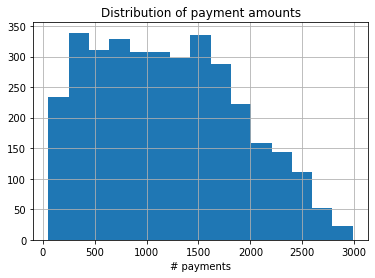

In [13]:
ax = payments['payment_amount'].hist(bins=15)
ax.set_xlabel('payment amount')
ax.set_xlabel('# payments')
ignore = ax.set_title('Distribution of payment amounts')

The distribution has a long tail on the right hand side. Most paymenta are in the range 500 to 1500. A significant number of them are less than 2000 with a very few of them above it.

2. Cumulative sum of number of clients per year.

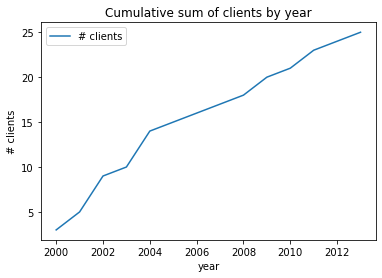

In [14]:
clients['joined_year'] = clients['joined'].dt.year
ax = clients[['client_id', 'joined_year']]. \
            groupby('joined_year'). \
            count(). \
            cumsum(). \
            reset_index(). \
            plot('joined_year', 'client_id',label='# clients')
ax.set_xlabel('year')
ax.set_ylabel('# clients')
ignore = ax.set_title('Cumulative sum of clients by year')

The maximum on this plot should match the total number of clients. The maximum is 25, so are the number of rows in the data frame <code>clients</code>.

3. Scatter plot of percentage of payments missed in December of every year.

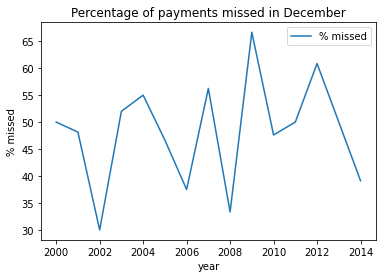

In [15]:
payments['payment_year'] = payments['payment_date'].dt.year
payments['payment_month'] = payments['payment_date'].dt.month
dec_count = payments.loc[payments['payment_month'] == 12]\
                        [['loan_id', 'payment_year']]. \
                        groupby('payment_year'). \
                        count(). \
                        rename(columns={'loan_id': 'n_loans'}). \
                        reset_index()
dec_missed_count = payments.loc[((payments['payment_month'] == 12) & (payments['missed'] == 1))] \
                               [['loan_id', 'payment_year']]. \
                               groupby('payment_year'). \
                               count(). \
                               rename(columns={'loan_id': 'n_loans_missed'}). \
                               reset_index()

X = pd.merge(dec_count, dec_missed_count, on='payment_year')
X['pct_missed'] = round(X['n_loans_missed']/X['n_loans'] * 100, 2)
ax = X.plot('payment_year', 'pct_missed', label = '% missed')
ax.set_xlabel('year')
ax.set_ylabel('% missed')
ignore = ax.set_title('Percentage of payments missed in December')

# Section 3 - Modelling

Create a model that will predict whether a person does or does not have diabetes. Use the diabetes.csv dataset. The target column in the dataset is "Outcome". Assume no features leak information about the target.

Your solution should include the below. You may use whichever python libraries you wish to complete the task:
1. Feature engineering
2. Model fitting and performance evaluation
3. A function that takes as arguments: a model, train data, test data, and returns the model's predictions on the test data
4. A function that takes a set of predictions and true values and that validates the predictions using appropriate metrics
5. Anything else you feel is necessary for modelling or improving the performance of your model


__This exercise is intended for you to show your proficiency in machine learning, understanding of the various techniques that can be employed to improve the performance of a model, and your ability to implement those techniques. Please, therefore, show your working at all times. You will be judged more for the above than for the performance of the final model your produce.__

## Data munging.

In [16]:
all_diab = pd.read_csv('test_diabetes.csv', sep=';')

In [17]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    object 
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    object 
dtypes: float64(7), object(2)
memory usage: 54.1+ KB


The attributes <code>Insulin</code> and <code>Outcome</code> have a data type <code>object</code>. They need a closer look.

In [18]:
all_diab['Insulin'].unique()

array(['0', '94', '168', 'Zero', '88', '543', '846', '175', '230', nan,
       '96', '235', '146', '115', '110', '245', '54', '192', '207', '70',
       '240', '82', '36', '23', '300', '342', '142', '128', '38', '90',
       '140', '270', '71', '125', '176', '48', '64', '228', '76', '220',
       '40', '152', '18', '135', '495', '37', '51', '100', '99', '145',
       '225', '49', '50', '92', '325', '63', '119', '204', '155', '485',
       '53', '114', '105', '285', '156', '78', '55', '130', '58', '160',
       '210', '318', '44', '190', '280', '271', '129', '120', '478', '56',
       '32', '370', '45', '194', '680', '402', '258', '375', '150', '67',
       '57', '116', '278', '122', '545', '75', '74', '182', '360', '215',
       '184', '42', '132', '148', '180', '205', '85', '231', '29', '68',
       '52', '255', '171', '73', '108', '83', '43', '167', '249', '293',
       '66', '465', '89', '158', '84', '72', '59', '81', '196', '415',
       '87', '275', '165', '579', '310', '61', '474

All values are interpreted as strings because a few of them are put as 'Zero'. We must convert them to '0'. Finally, we must make everything numeric.

In [19]:
all_diab.loc[all_diab['Insulin'] =='Zero', 'Insulin'] = 0
all_diab['Insulin'] = all_diab['Insulin'].apply(lambda s: float(s))

In [20]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    float64
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    object 
dtypes: float64(8), object(1)
memory usage: 54.1+ KB


Let us now look at unique values of <code>Outcome</code>.

In [21]:
all_diab['Outcome'].unique()

array(['1', '0', 'N', 'Y'], dtype=object)

Some values are marked 'N' and 'Y'. We must replace them with '0' and '1' and finally convert all of them to integers.

In [22]:
all_diab.loc[all_diab['Outcome'] == 'N', 'Outcome'] = '0'
all_diab.loc[all_diab['Outcome'] == 'Y', 'Outcome'] = '1'
all_diab['Outcome'].unique()

array(['1', '0'], dtype=object)

In [23]:
all_diab['Outcome'] = all_diab['Outcome'].apply(lambda s: int(s))

In [24]:
all_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    float64
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


We now have all values as numbers in the data frame. Yet, there are a few NaNs. How many rows have NaNs?

In [25]:
bad_data = all_diab[all_diab.applymap(np.isnan).any(True)]

print(f'{round(100 * bad_data.shape[0]/all_diab.shape[0], 2)} % of rows have NaNs')

34.51 % of rows have NaNs


A whopping 35% of observations have NaNs. We cannot just ignore all of it. How are the NaNs distributed across attributes?

In [26]:
all_diab.shape[0] - all_diab.describe().loc[['count']]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,37.0,38.0,34.0,34.0,51.0,35.0,40.0,51.0,0.0


The number of NaNs for each attribute are limited. They are atmost 6.6% (51/768). Therefore, we can impute them with medians.

In [27]:
all_diab = all_diab.fillna(all_diab.median())
all_diab.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.785156,120.946615,69.140625,20.944010,77.072917,31.980469,0.467483,33.769531,0.348958
std,3.291875,30.990784,19.068969,15.527097,110.316623,7.735926,0.323716,15.626516,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,-1.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.500000,0.251000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,122.000000,36.225000,0.602000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,200.000000,1.000000


Age has a minimum of $-1$ and a maximum of $200$. Let if find out how many observations have unreasonable ages.

In [37]:
all_diab.loc[((all_diab['Age'] < 0) | (all_diab['Age'] > 95)), ]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
100,1.0,163.0,72.0,0.0,0.0,39.0,1.2220,-1.0,1
230,4.0,142.0,86.0,0.0,0.0,44.0,0.6450,-1.0,1
450,1.0,82.0,64.0,13.0,95.0,21.2,0.3725,170.0,0
451,2.0,134.0,70.0,0.0,0.0,28.9,0.3725,200.0,1
600,1.0,108.0,88.0,19.0,0.0,27.1,0.4000,190.0,0
620,2.0,112.0,72.0,42.0,160.0,38.4,0.2460,150.0,0


I will replace these abnormal values with median of age.

In [42]:
all_diab.loc[((all_diab['Age'] < 0) | (all_diab['Age'] > 95)), 'Age'] = statistics.median(all_diab['Age'])

Check if the values look OK.

In [43]:
all_diab.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.785156,120.946615,69.140625,20.944010,77.072917,31.980469,0.467483,33.074219,0.348958
std,3.291875,30.990784,19.068969,15.527097,110.316623,7.735926,0.323716,11.448585,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.500000,0.251000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,122.000000,36.225000,0.602000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


I will save the cleaned data for analysis beyond this test.

In [45]:
all_diab.to_csv('clean_diabetes.csv')

## Preliminary examination of the data

How skewed are the predictors?

In [46]:
all_diab.describe().loc[['mean', '50%']] # Compare the mean with the median.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
mean,3.785156,120.946615,69.140625,20.94401,77.072917,31.980469,0.467483,33.074219,0.348958
50%,3.000000,117.000000,72.000000,23.00000,36.000000,32.000000,0.372500,29.000000,0.000000


Most means are close to their respective medians, except Insulin. The outliers are likely to emerge from here.

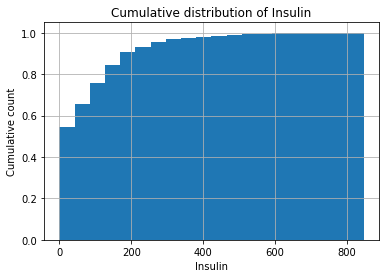

In [47]:
ax = all_diab['Insulin'].hist(cumulative=True, bins = 20, density=1)
ax.set_xlabel('Insulin')
ax.set_ylabel('Cumulative count')
ignore = ax.set_title('Cumulative distribution of Insulin')

95% of subjects have Insulin < 400. I will create a separate data set without them.

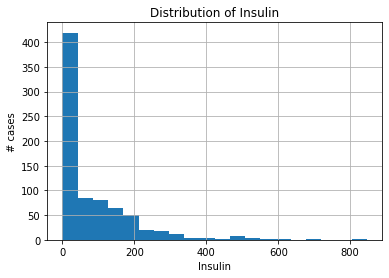

In [51]:
ax = all_diab['Insulin'].hist(bins=20)
ax.set_xlabel('Insulin')
ax.set_ylabel('# cases')
ignore = ax.set_title('Distribution of Insulin')

Insulin values are indeed skewed a lot and we should not expect the mean and the median to be too close.

In [116]:
D = all_diab.loc[all_diab['Insulin'] < 400]
D.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,3.79600,120.124000,69.016000,20.616000,66.373333,31.891600,0.466344,33.782667,0.342667
std,3.29457,30.675429,19.213987,15.493976,85.567449,7.740028,0.320410,15.686157,0.474918
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,-1.000000,0.000000
25%,1.00000,100.000000,64.000000,0.000000,0.000000,27.500000,0.251000,24.000000,0.000000
50%,3.00000,117.000000,72.000000,23.000000,36.000000,32.000000,0.372500,29.000000,0.000000
75%,6.00000,138.000000,78.000000,32.000000,115.000000,36.100000,0.600000,40.000000,1.000000
max,17.00000,198.000000,122.000000,99.000000,392.000000,67.100000,2.420000,200.000000,1.000000


I am OK to lose approximately 2.35% of data. Even now the gap between mean and median is large, but let is live with it for the moment.

Are there any correlations among the predictors? We will examine using pair plots.

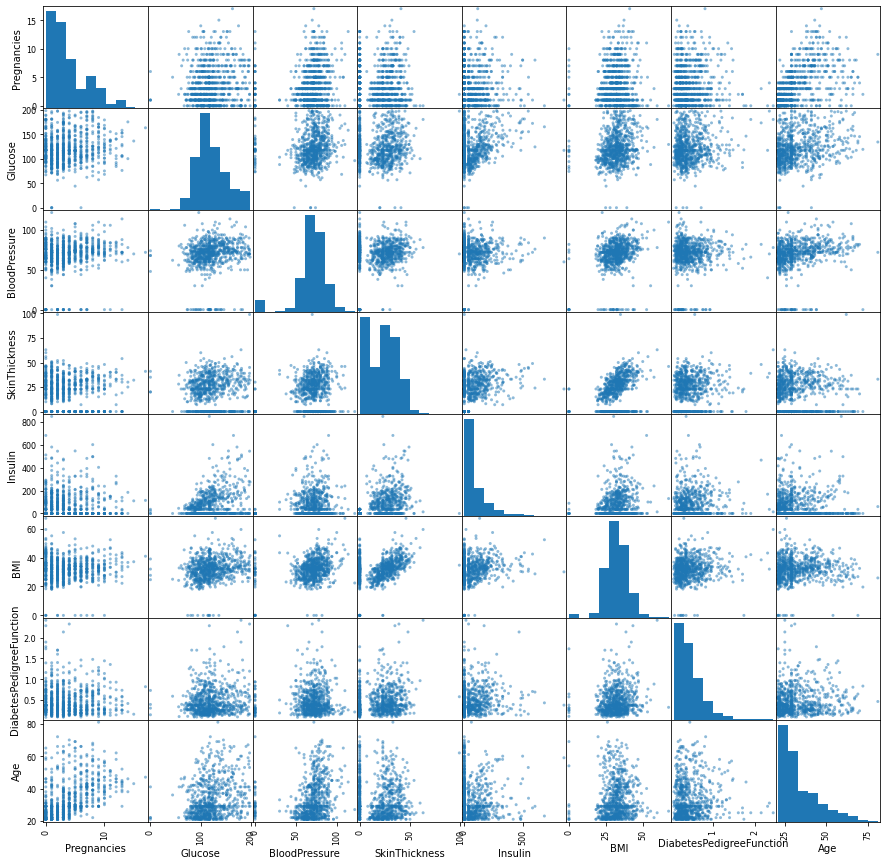

In [52]:
all_Xs = ['Pregnancies',
          'Glucose',
          'BloodPressure',
          'SkinThickness',
          'Insulin',
          'BMI',
          'DiabetesPedigreeFunction',
          'Age']
smat = pd.plotting.scatter_matrix(all_diab[all_Xs], figsize=(15, 15))

There are no strong correlations among the predictors except for a trend between <code>BMI</code> and <code>SkinThickness</code>. If I have to choose one among them, I would choose <code>BMI</code> because of the short gap between its mean and median. But I will finalize my decision based on t-test.

In [118]:
Y = 'Outcome'
for x in all_Xs:
  print(all_diab[[x, Y]].groupby(Y).mean().round(2).transpose())
  print(stats.f_oneway(all_diab.loc[all_diab[Y]==0][x], all_diab.loc[all_diab[Y]==1][x]))
  print('-' * 80)

Outcome         0     1
Pregnancies  3.27  4.75
F_onewayResult(statistic=36.72476059147227, pvalue=2.1329943841169955e-09)
--------------------------------------------------------------------------------
Outcome       0       1
Glucose  110.48  140.48
F_onewayResult(statistic=207.6203557221851, pvalue=7.935358051128253e-42)
--------------------------------------------------------------------------------
Outcome            0      1
BloodPressure  68.34  70.63
F_onewayResult(statistic=2.5308490913930197, pvalue=0.11205271603329084)
--------------------------------------------------------------------------------
Outcome            0      1
SkinThickness  20.16  22.41
F_onewayResult(statistic=3.6845965993834096, pvalue=0.05528843662170775)
--------------------------------------------------------------------------------
Outcome      0      1
Insulin  66.26  97.25
F_onewayResult(statistic=14.004335855980598, pvalue=0.00019602410892913364)
-----------------------------------------------------

Even ANOVA recommends <code>BMI</code> over <code>SkinThickness</code>. Further, <code>BloodPressure</code> does not seem to have a strong influence on the <code>Outcome</code>.

## Logistic regression

I will first define a few helper functions.

In [119]:
def trn_tst_split(data, trn_pct):
    """Split the data set into training and test.
    
        data: the data frame to be split.
        trn_pct: % of training data. Must be between 0 and 1.
        
        Returns a list of two data frames - training and test.
    """
    random.seed(12111842)
    N = data.shape[0]
    n_train = int(N * trn_pct)
    trn_indices = set(random.sample(range(N), n_train))
    tst_indices = set(range(N)) - trn_indices
    
    assert len(trn_indices.intersection(tst_indices)) == 0
    assert len(trn_indices) + len(tst_indices) == N
    
    # Convert them to lists.
    trn_indices = [i for i in trn_indices]
    tst_indices = [i for i in tst_indices]
    
    trn_data = data.iloc[trn_indices, :]
    tst_data = data.iloc[tst_indices, :]
    
    assert trn_data.shape[0] + tst_data.shape[0] == data.shape[0]
    
    return [trn_data, tst_data]


def print_cm_results(cm):
    """Print diagnostics from the confusion matrix."""
    recall = cm[0, 0]/(cm[0, 0] + cm[1, 0])
    precision = cm[0, 0]/(cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1]/(cm[1, 0] + cm[1, 1])
    f1_score = 2*recall*precision/(recall + precision)
    accuracy = np.trace(cm)/np.sum(cm)
    
    print(f'% +ves correctly predicted (recall) = {round(recall * 100, 2)}')
    print(f'% +ves detected out of all (precision) = {round(precision * 100, 2)}')
    print(f'% -ves detected out of all (specificity) = {round(specificity * 100, 2)}')
    print(f'f1 score = {round(f1_score, 2)}')
    print(f'accuracy = {round(accuracy * 100, 2)}')

I next list the 'formulae' (similar to the ones used in R) used to define the linear models.

In [120]:
# First model takes all X's, ignoring the preliminary investigation.
f_v0 = 'Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age'
# We know that blood pressure does not matter and skin thickness is correlated to BMI. We drop them.
f_v1 = 'Outcome ~ Pregnancies + Glucose + Insulin + BMI + DiabetesPedigreeFunction + Age'

In [121]:
def get_model_matrices(D, formula):
    return dmatrices(formula, data=D, return_type='dataframe')

In [122]:
trn_data, tst_data = trn_tst_split(D, 0.75)

In [123]:
# Training model matrices for model with version 0.
yn_v0, Xn_v0 = get_model_matrices(trn_data, f_v0)
# Training model matrices for model with version 1.
yn_v1, Xn_v1 = get_model_matrices(trn_data, f_v1)

Run the two models and get their confusion matrices on the **training** data.

In [124]:
model_v0 = sm.Logit(yn_v0, Xn_v0)
results_v0 = model_v0.fit()
cm_v0 = results_v0.pred_table()
print(results_v0.summary())

print()
print('-' * 80)
print()

model_v1 = sm.Logit(yn_v1, Xn_v1)
results_v1 = model_v1.fit()
cm_v1 = results_v1.pred_table()
print(results_v1.summary())

Optimization terminated successfully.
         Current function value: 0.474650
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  562
Model:                          Logit   Df Residuals:                      553
Method:                           MLE   Df Model:                            8
Date:                Fri, 11 Sep 2020   Pseudo R-squ.:                  0.2697
Time:                        16:54:04   Log-Likelihood:                -266.75
converged:                       True   LL-Null:                       -365.27
Covariance Type:            nonrobust   LLR p-value:                 2.699e-38
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.5862      0.867     -9.898      0.000     -10.286

Key observations in model version 0.
1. The coefficients of <code>Insulin</code> and <code>SkinThickness</code> are not statistically significant.
2. The pseudo-R2 for the model is 26%. Not bad for a biological system.

Key observations in model version 1.
1. <code>Insulin</code> and <code>Age</code> must be dropped.
2. The pseudo-R2 has dropped a bit but not too alarmingly.

In [125]:
# We know that blood pressure does not matter and skin thickness is correlated to BMI. We drop them.
f_v2 = 'Outcome ~ Pregnancies + Glucose + BMI + DiabetesPedigreeFunction'
# Training model matrices for model with version 2.
yn_v2, Xn_v2 = get_model_matrices(trn_data, f_v2)
model_v2 = sm.Logit(yn_v2, Xn_v2)
results_v2 = model_v2.fit()
cm_v2 = results_v2.pred_table()
print(results_v2.summary())

Optimization terminated successfully.
         Current function value: 0.482990
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  562
Model:                          Logit   Df Residuals:                      557
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 Sep 2020   Pseudo R-squ.:                  0.2569
Time:                        16:54:05   Log-Likelihood:                -271.44
converged:                       True   LL-Null:                       -365.27
Covariance Type:            nonrobust   LLR p-value:                 1.690e-39
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.7120      0.814    -10.707      0.000     -10.307

All regression coefficients are significant but pseudo-R2 has dropped by 0.5%. Let us now look at the confusion matrices on the **training** data for all the models.

In [126]:
# Print all confusion matrices
cms = [cm_v0, cm_v1, cm_v2]
for i, cm in enumerate(cms):
    print(f'Confusion matrix for version {i}:')
    print_cm_results(cm)
    print('-' * 80)

Confusion matrix for version 0:
% +ves correctly predicted (recall) = 77.43
% +ves detected out of all (precision) = 87.88
% -ves detected out of all (specificity) = 53.27
f1 score = 0.82
accuracy = 75.62
--------------------------------------------------------------------------------
Confusion matrix for version 1:
% +ves correctly predicted (recall) = 77.86
% +ves detected out of all (precision) = 88.15
% -ves detected out of all (specificity) = 54.27
f1 score = 0.83
accuracy = 76.16
--------------------------------------------------------------------------------
Confusion matrix for version 2:
% +ves correctly predicted (recall) = 77.11
% +ves detected out of all (precision) = 88.15
% -ves detected out of all (specificity) = 52.26
f1 score = 0.82
accuracy = 75.44
--------------------------------------------------------------------------------


Version 0 seems to be the best on the training data. We will now find out how these model fare on the test data. 

But before we do that, we need a helper function.  

In [127]:
def prob_to_outcome(y, threshold = 0.5):
    """Converts probability to a class depending on the threshold."""
    if y < threshold:
        return 0
    else:
        return 1
    
def build_cm(yt, yp):
    """Generates confusion matrix from actual and predicted values."""
    yt['predicted'] = [prob_to_outcome(y) for y in yp]
    yt.columns = ['actual', 'predicted']
    yt['actual'] = yt['actual'].apply(lambda f: int(f))
    cm = pd.crosstab(yt['actual'], yt['predicted']).to_numpy()
    
    return cm
    

In [128]:
# Get the design matrices.
yt_v0, Xt_v0 = get_model_matrices(tst_data, f_v0)
yt_v1, Xt_v1 = get_model_matrices(tst_data, f_v1)
yt_v2, Xt_v2 = get_model_matrices(tst_data, f_v2)

# Get the predictions.
yp_v0 = results_v0.predict(Xt_v0)
yp_v1 = results_v1.predict(Xt_v1)
yp_v2 = results_v2.predict(Xt_v2)

cm_v0 = build_cm(yt_v0, yp_v0)
cm_v1 = build_cm(yt_v1, yp_v1)
cm_v2 = build_cm(yt_v2, yp_v2)

# Print all confusion matrices
cms = [cm_v0, cm_v1, cm_v2]
for i, cm in enumerate(cms):
    print(f'Confusion matrix for version {i}:')
    print_cm_results(cm)
    print('-' * 80)

Confusion matrix for version 0:
% +ves correctly predicted (recall) = 83.33
% +ves detected out of all (precision) = 88.46
% -ves detected out of all (specificity) = 60.34
f1 score = 0.86
accuracy = 79.79
--------------------------------------------------------------------------------
Confusion matrix for version 1:
% +ves correctly predicted (recall) = 82.86
% +ves detected out of all (precision) = 89.23
% -ves detected out of all (specificity) = 58.62
f1 score = 0.86
accuracy = 79.79
--------------------------------------------------------------------------------
Confusion matrix for version 2:
% +ves correctly predicted (recall) = 82.27
% +ves detected out of all (precision) = 89.23
% -ves detected out of all (specificity) = 56.9
f1 score = 0.86
accuracy = 79.26
--------------------------------------------------------------------------------


Version 2 seems to better than the previous ones. We choose it.

Before closing, I will write a function asked in point 3. Our model and the design matrices depend on the formula. Therefore, instead of passing model as the first parameter, we pass the formula, a string. 

In [129]:
def run_model_on_test_data(formula, train, test, threshold = 0.5):
    """Get predictions of a model on test data.
    
        formula:   a string describing the linear model.
        train:     the training data set.
        test:      the test data set.
        threshold: a cut off applied to the probabilities to decide the class.
    """
    yn, Xn = get_model_matrices(train, formula)
    yt, Xt = get_model_matrices(test, formula)
    
    model = sm.Logit(yn, Xn)
    results = model.fit()
    yp = results.predict(Xt)
    
    return yp

We will test this function on version 2.

In [130]:
yp2 = run_model_on_test_data(f_v2, trn_data, tst_data)

Optimization terminated successfully.
         Current function value: 0.482990
         Iterations 6


Check it the results match.

In [131]:
assert max(abs(yp2 - yp_v2)) == 0.0

Suggested next steps:
1. The specificity of the model is 57%. It means that 43% of the cases classified as diabetic turn out to be not so. I think in this case, it is OK to suspect someone of being diabetic and putting her on medications than otherwise. Do we need to adjust the threshold to decrease specificity and reduce the false positives? (False positive in this case means that the model declared that the person is not diabetic but she turned out to be one.)
2. I have used one split between training and test data. Ideally, one must cross-validate extensively. It is possible to do 30 cross-validations using 'hold-25' strategy. I do not know if this can be done automatically in Python. In R it is just a function call.
3. I would like to see how Naive Bayes performs on this data. Of the four predictors in the version 2 of the model, two appear Gaussian but <code>Pregnancy</code> and <code>DiabetesPedigreeFunction</code> are conspicuously non-Gaussian. I don't know if I can use a Naive Bayesian classifier on such a combination of predictors.
4. It is always worth the efforts to check if a random forest classifier does a better job.